In [1]:
#chat GPT is credited when used
!pip install anndata
!pip install 'scanpy[leiden]'

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scanpy as sc
import seaborn as sns

We initialize the anndata object.

In [210]:
extract_dir = "/Users/valeriepersonal/applieddatasci/" 
adata = sc.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # file path

/Users/valeriepersonal/anaconda3/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

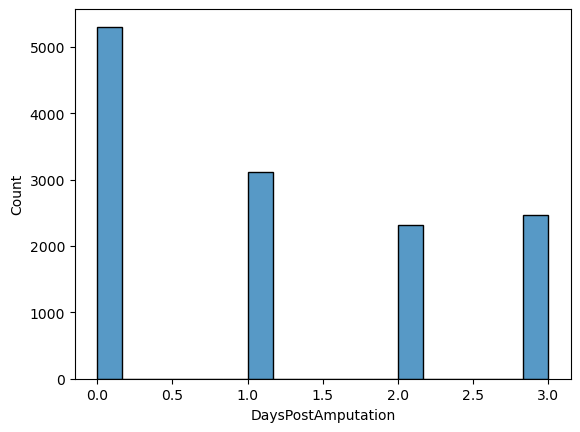

In [19]:
sns.histplot(adata.obs['DaysPostAmputation'])

In [20]:
np.unique(adata.obs['DaysPostAmputation']) #verifying that options are 0, 1, 2, 3

array([0, 1, 2, 3])

In [212]:
adata = adata[adata.obs['DaysPostAmputation'] == 2] # Subset on the time point 2
adata.layers['counts'] = adata.X.copy() # copying the raw counts 

/var/folders/50/f800h9h175bcf3mxpdj030r80000gn/T/ipykernel_25707/2206150560.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


In [213]:
sc.pp.filter_genes(adata, min_cells=2)
sc.pp.filter_cells(adata, min_counts=200) 

In [214]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

mt_pct = adata.obs['pct_counts_mt']

threshold = np.percentile(mt_pct, 95)

adata = adata[mt_pct <= threshold, :]

print(f"Number of cells remaining after filtering: {adata.n_obs}")


Number of cells remaining after filtering: 2310


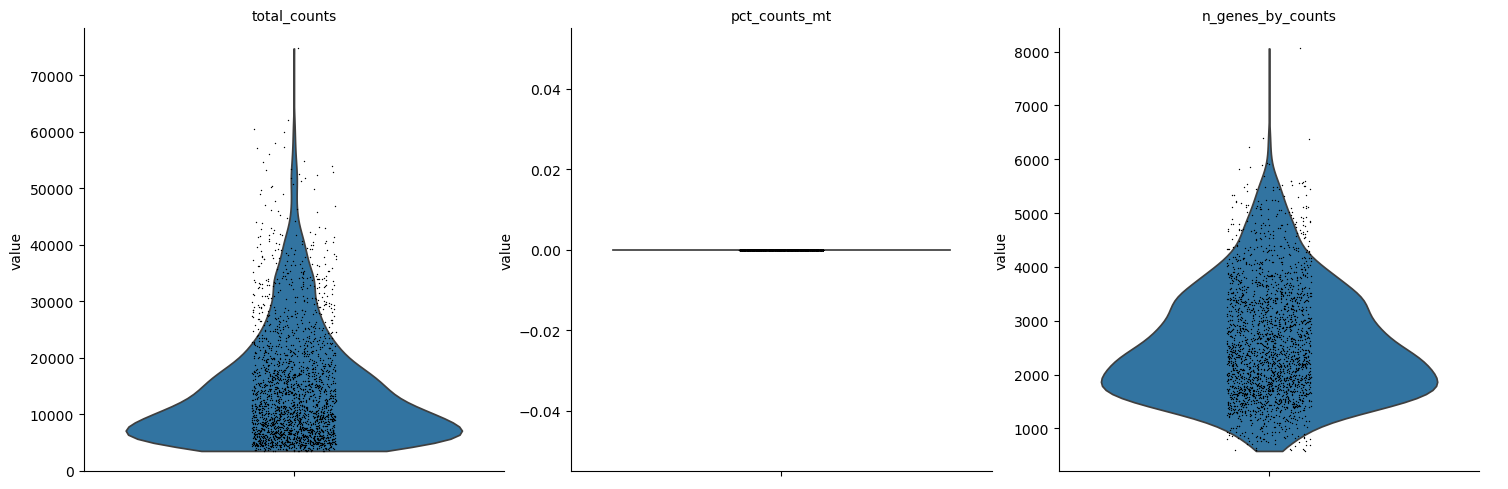

In [215]:
sc.pl.violin(adata,['total_counts','pct_counts_mt','n_genes_by_counts'],multi_panel=True) #violin plot

In [216]:
sc.pp.normalize_total(adata, target_sum=None) 
sc.pp.log1p(adata, base =2)  
sc.pp.highly_variable_genes(adata, n_top_genes=1980) #top 15% most highly variable genes

/Users/valeriepersonal/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


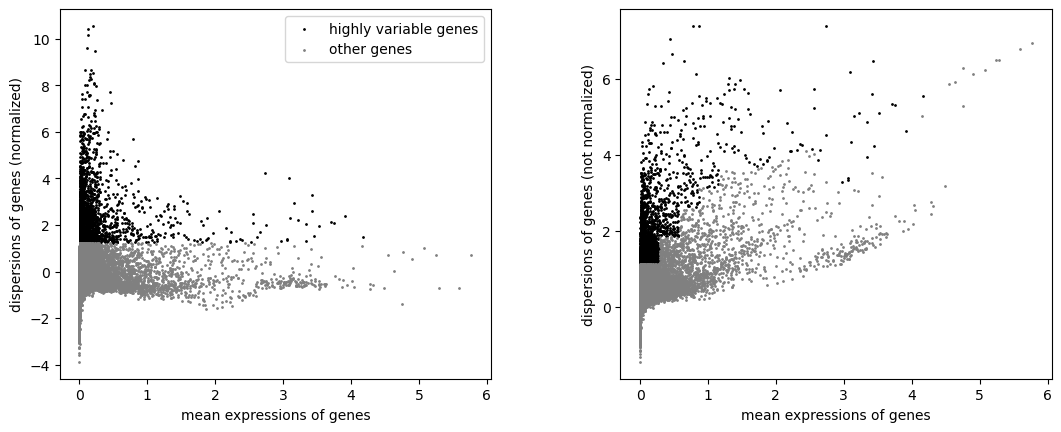

In [217]:
sc.pl.highly_variable_genes(adata)

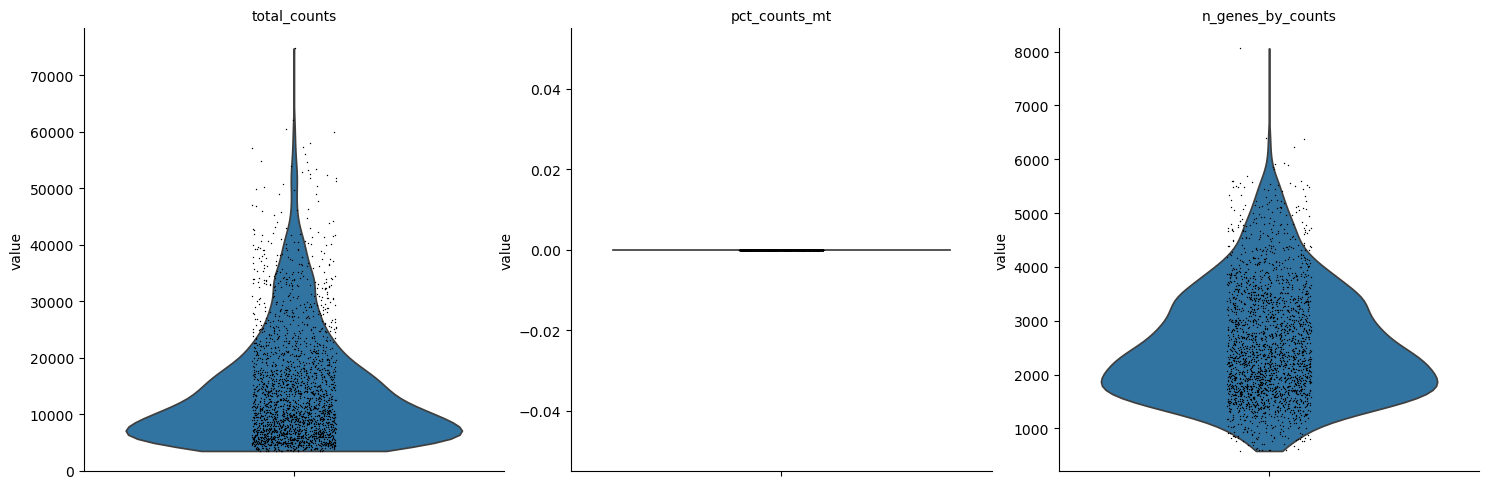

In [218]:
sc.pl.violin(adata,['total_counts','pct_counts_mt','n_genes_by_counts'],multi_panel=True) #looks different from the one i did before

## PCA


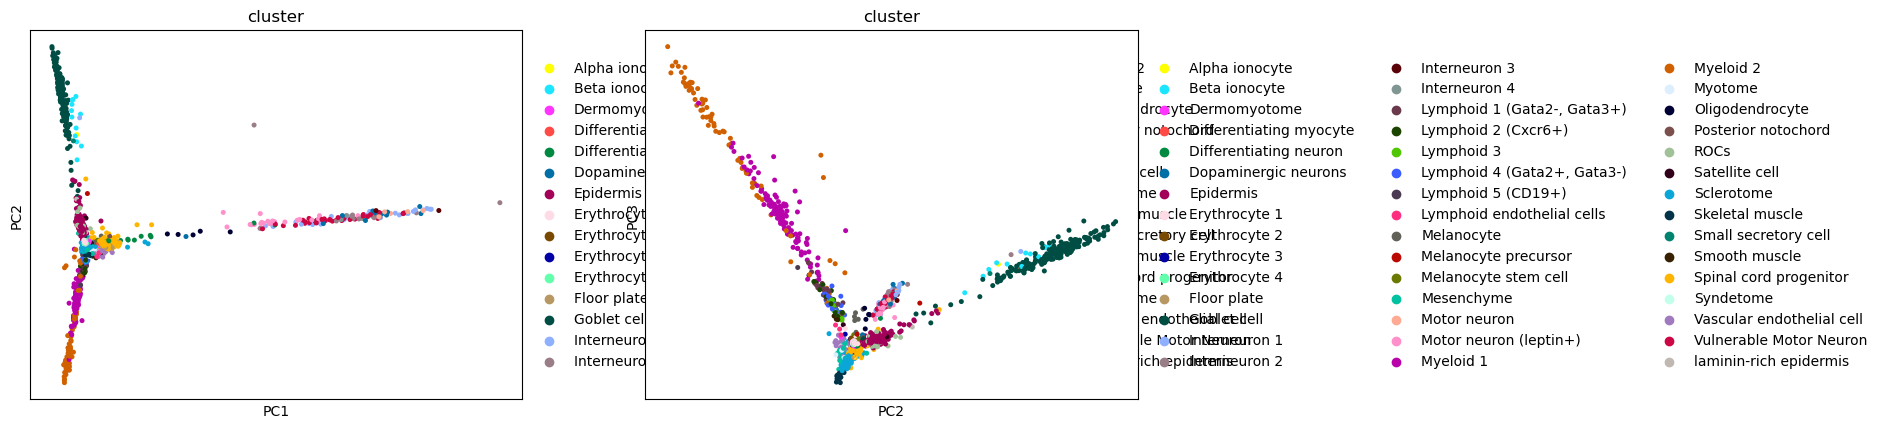

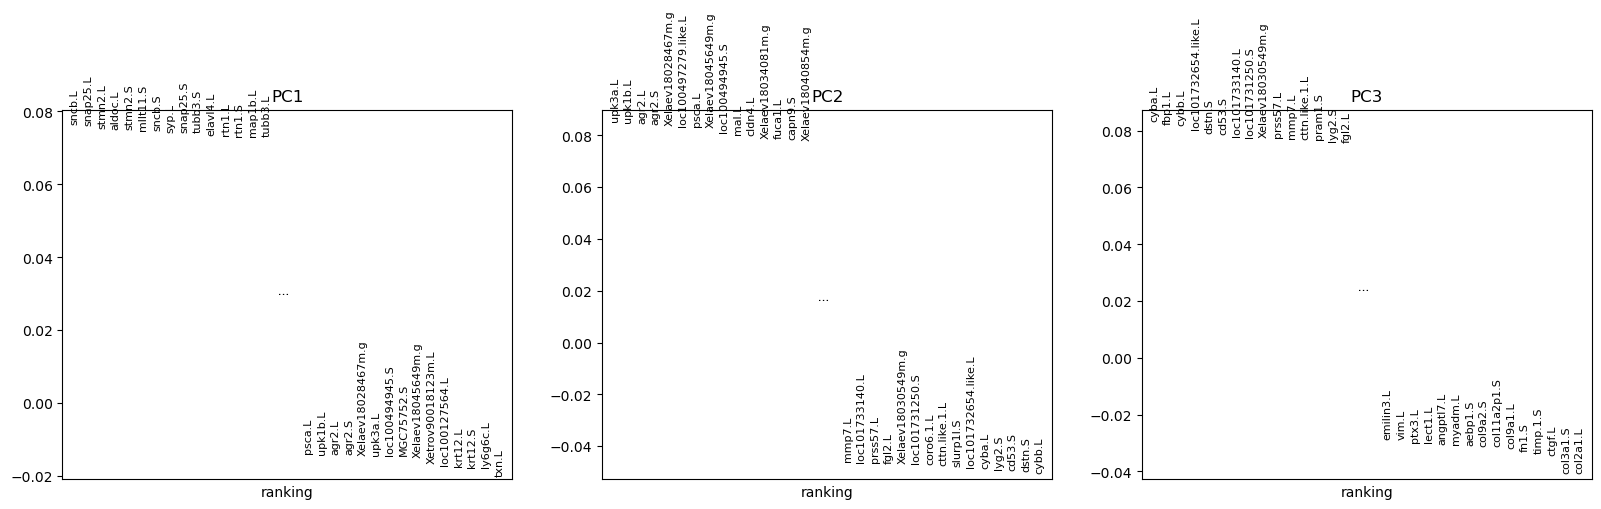

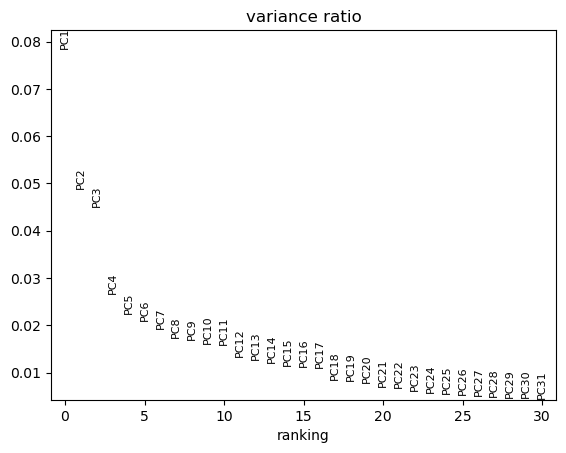

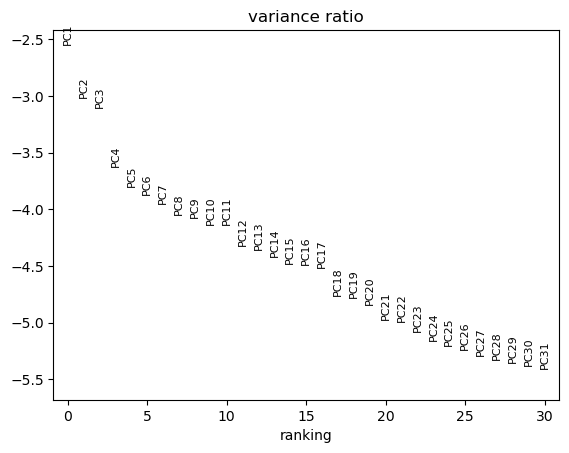

In [223]:
sc.pp.scale(adata) # Scales the data - make sure all features contribute equally to the analysis
sc.pp.pca((adata)) #prepares the data for PCA clustering
sc.tl.pca((adata)) #actually completes the PCA clustering

sc.pl.pca_overview((adata), color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
#identify how the clustering performs
sc.pl.pca_variance_ratio(adata, log=True) #generates a plot demonstrating proportion of variance explained by each PC
#variance on y-axis is on a log scale
#Typically, you would look for a "elbow" in the plot, which indicates the point beyond which additional components contribute diminishing returns to the explained variance.


In [222]:
variance_rat =adata.uns['pca']['variance_ratio'][:15]

variance_percentage = variance_rat * 100
cumulative_percentage = np.cumsum(variance_percentage)
for i, cum_var in enumerate(cumulative_percentage):
    print(f"Cumulative PC{i + 1}: {cum_var:.2f}% variance explained")

Cumulative PC1: 7.85% variance explained
Cumulative PC2: 12.74% variance explained
Cumulative PC3: 17.24% variance explained
Cumulative PC4: 19.91% variance explained
Cumulative PC5: 22.14% variance explained
Cumulative PC6: 24.23% variance explained
Cumulative PC7: 26.16% variance explained
Cumulative PC8: 27.90% variance explained
Cumulative PC9: 29.60% variance explained
Cumulative PC10: 31.20% variance explained
Cumulative PC11: 32.79% variance explained
Cumulative PC12: 34.11% variance explained
Cumulative PC13: 35.39% variance explained
Cumulative PC14: 36.59% variance explained
Cumulative PC15: 37.73% variance explained


In [45]:
differences = np.diff(variance_ratios)
for i in range(len(differences)):
    print(f"Difference between PC{i + 1} and PC{i + 2}: {differences[i]:.4f}")

Difference between PC1 and PC2: -0.0296
Difference between PC2 and PC3: -0.0039
Difference between PC3 and PC4: -0.0184
Difference between PC4 and PC5: -0.0043
Difference between PC5 and PC6: -0.0015
Difference between PC6 and PC7: -0.0015
Difference between PC7 and PC8: -0.0019
Difference between PC8 and PC9: -0.0005
Difference between PC9 and PC10: -0.0009
Difference between PC10 and PC11: -0.0001
Difference between PC11 and PC12: -0.0027
Difference between PC12 and PC13: -0.0005
Difference between PC13 and PC14: -0.0008
Difference between PC14 and PC15: -0.0007


In [225]:
# Whitening step

sc.pp.neighbors(adata, n_pcs=8)
sc.tl.umap(adata)


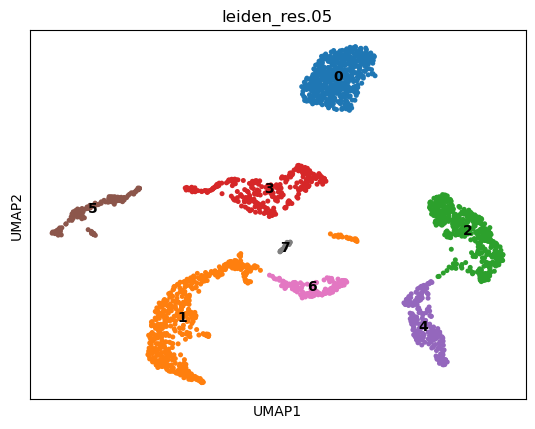

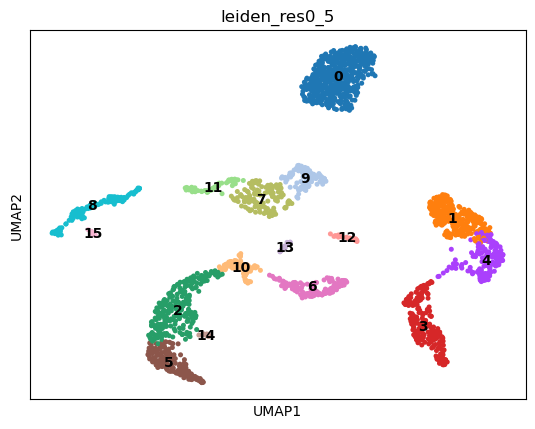

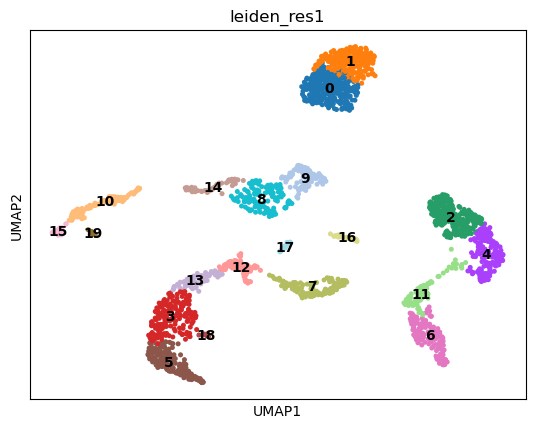

In [226]:
sc.tl.leiden(adata, key_added="leiden_res.05", resolution=0.05)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1)


sc.pl.umap(adata, color="leiden_res.05", legend_loc="on data")
sc.pl.umap(adata, color="leiden_res0_5", legend_loc="on data")
sc.pl.umap(adata, color="leiden_res1", legend_loc="on data")



## K-means clustering

In [227]:
import sklearn.cluster
kmeans = sklearn.cluster.KMeans().fit(adata.obsm['X_pca'][:, :15])
adata.obs['kmeans_clust'] = kmeans.labels_.astype(str)

/Users/valeriepersonal/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


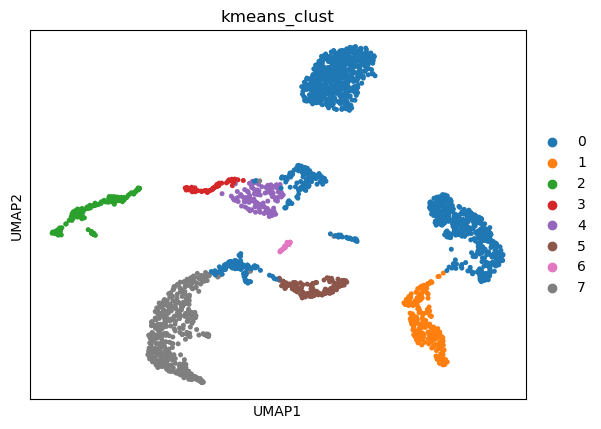

In [228]:
sc.pl.umap(adata, color = ['kmeans_clust'])


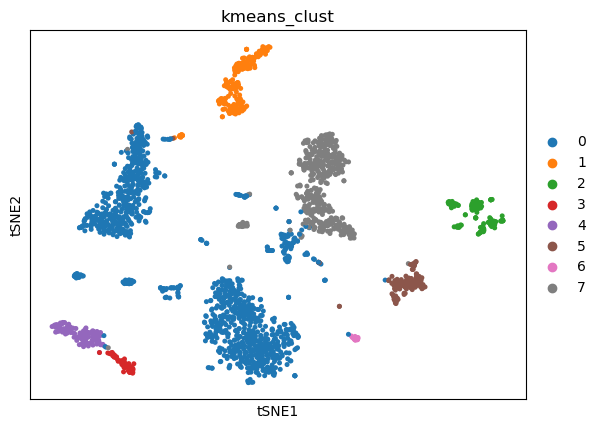

In [229]:
sc.tl.tsne(adata, perplexity=30, learning_rate=200, random_state=0)
sc.pl.tsne(adata, color='kmeans_clust')


## Computing clustering metrics for knn

### Rand Index, adjusted rand index

In [83]:
from sklearn import metrics

In [86]:
rand_index = metrics.rand_score(adata.obs['cluster'], adata.obs['kmeans_clust'])
print('The Rand index for the k-nearest neighbors clustering is ', round(rand_index, 4))

The Rand index the knn clustering is  0.7615


In [111]:
adj_rand_index = metrics.adjusted_rand_score(adata.obs['cluster'],adata.obs['kmeans_clust'])

print('The adjusted Rand index for the k-nearest neighbors clustering is', round(adj_rand_index, 4))

The adjusted Rand index for the k-nearest neighbors clustering is 0.3199


### Silhouette score

In [114]:
silhouette_avg = metrics.silhouette_score(adata.X, adata.obs['kmeans_clust'].astype(int))
print(silhouette_avg)

0.03222306769185277


In [108]:
metrics.adjusted_mutual_info_score(adata.obs['cluster'], adata.obs['kmeans_clust'].astype(int))

0.6241291605793127

## Computing clustering metrics for PCA-Leiden clustering:

In [116]:
rand_index_leiden = metrics.rand_score(adata.obs['cluster'], adata.obs['leiden_res0_5'])
print('The Rand index for the PCA-Leiden clustering is ', round(rand_index_leiden, 4))

The Rand index for the PCA-Leiden clustering is  0.9202


In [118]:
adj_rand_index_leiden = metrics.adjusted_rand_score(adata.obs['cluster'], adata.obs['leiden_res0_5'])

print('The adjusted Rand index for the PCA-Leiden clustering is ', round(adj_rand_index_leiden, 4))

The adjusted Rand index for the PCA-Leiden clustering is  0.5603


In [124]:
silhouette_avg_leiden = metrics.silhouette_score(adata.X, adata.obs['leiden_res0_5'].astype(int))
print(silhouette_avg_leiden)

-0.03364400148029511


### Bonus - NMI

In [125]:
metrics.adjusted_mutual_info_score(adata.obs['cluster'], adata.obs['leiden_res0_5'].astype(int))

0.7659766069020758

## Part 2: Marker Identification and Gene Analysis

In [361]:
# Perform differential gene expression analysis WILCOXON TC
sc.tl.rank_genes_groups(adata, groupby='cluster',groups=['ROCs'], method='wilcoxon', use_raw=False, tie_correct=True)

result = adata.uns['rank_genes_groups']


/Users/valeriepersonal/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


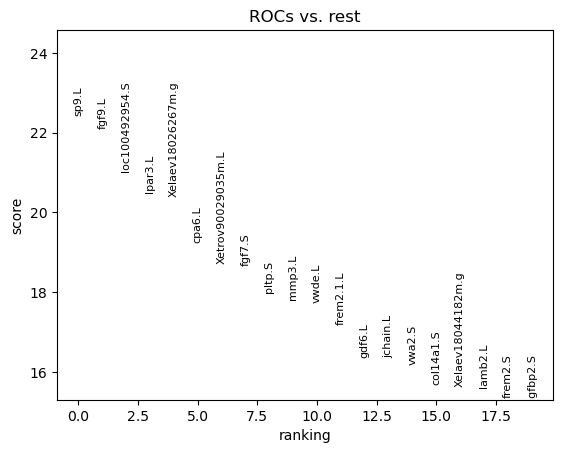

In [289]:
sc.pl.rank_genes_groups(adata)

In [374]:
df1 = sc.get.rank_genes_groups_df(adata, group='ROCs').head(20)

df1['names']

0     apoc1.like.L
1          azin2.S
2            mdk.S
3            mdk.L
4          epcam.L
5        col14a1.S
6            id3.S
7          epcam.S
8         krt5.7.S
9        s100a11.L
10           id3.L
11         sparc.S
12          myh9.S
13        tmsb4x.L
14         krt12.L
15         bambi.L
16         krt18.L
17        igfbp2.S
18         fras1.L
19         lama5.L
Name: names, dtype: object

In [373]:
# Perform differential gene expression analysis t-test
sc.tl.rank_genes_groups(adata, groupby='cluster',groups=['ROCs'], method='t-test', use_raw=False)

result_t = adata.uns['rank_genes_groups']

/Users/valeriepersonal/anaconda3/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


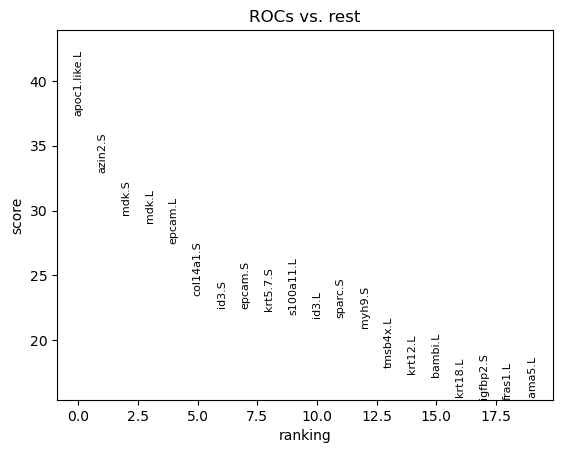

In [273]:
sc.pl.rank_genes_groups(adata)

In [294]:
df2 = sc.get.rank_genes_groups_df(adata, group='ROCs').head(20)

In [295]:
#df2['names']

0                 sp9.L
1                fgf9.L
2        loc100492954.S
3               lpar3.L
4     Xelaev18026267m.g
5                cpa6.L
6     Xetrov90029035m.L
7                fgf7.S
8                pltp.S
9                mmp3.L
10               vwde.L
11            frem2.1.L
12               gdf6.L
13             jchain.L
14               vwa2.S
15            col14a1.S
16    Xelaev18044182m.g
17              lamb2.L
18              frem2.S
19             igfbp2.S
Name: names, dtype: object

### ROCs in dataset according to cluster label

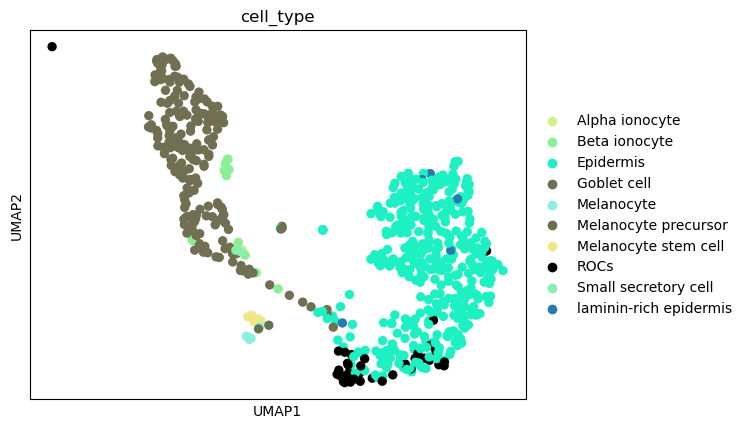

In [365]:
#partially assisted by code from ChatGPT which I then debugged and added my own parameters to

# Focus on skin-related clusters (including ROCs)
skin_related_clusters = ['ROCs','Epidermis', 'laminin-rich epidermis',  'Melanocyte precursor', 'Melanocyte stem cell','Melanocyte', 'Goblet cell','Alpha ionocyte', 'Beta ionocyte','Small secretory cell']

# Filter adata object to include cells from skin clusters
adata_skin_related = adata[adata.obs['cluster'].isin(skin_related_clusters)].copy()

# Create a new column to differentiate between ROCs and other skin cells
adata_skin_related.obs['cell_type'] = adata_skin_related.obs['cluster']


# UMAP 
sc.tl.umap(adata_skin_related)
sc.pl.umap(adata_skin_related, color='cell_type', palette=['#D2F089', '#89F093', '#1DF0C2', '#706F52', '#89F0E2', '#687052', '#F0E589', 'black', '#89F0B5', '#287BAE'])


### Finding ROCs based on markers

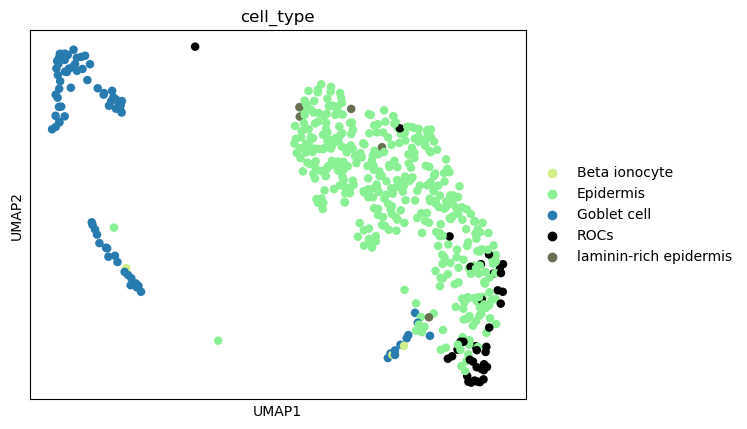

In [375]:
#partially assisted by code from ChatGPT which I then debugged and added my own parameters to

# Define your gene markers
gene_markers = df1['names']  

# Focus on skin-related clusters (including ROCs)
skin_related_clusters = ['ROCs', 'Epidermis', 'laminin-rich epidermis', 'Melanocyte precursor', 
                         'Melanocyte stem cell', 'Melanocyte', 'Goblet cell', 'Alpha ionocyte', 
                         'Beta ionocyte', 'Small secretory cell']

# Filter the AnnData object to only include cells from skin clusters
adata_skin_related = adata[adata.obs['cluster'].isin(skin_related_clusters)].copy()

# Ensure the gene markers exist in the dataset
valid_genes = [gene for gene in gene_markers if gene in adata.var_names]

if not valid_genes:
    raise ValueError("None of the specified genes are found in the dataset!")

# Subset the skin-related cells for these genes
adata_skin_related_sub = adata_skin_related[:, valid_genes].copy()

# Set an expression threshold to identify cells expressing these genes
expression_threshold = .4  
cell_mask = np.array((adata_skin_related_sub.X.mean(axis=1) > expression_threshold))

# Subset adata to include only cells expressing the markers
adata_skin_filtered = adata_skin_related[cell_mask].copy()

# differentiate between ROCs and other skin
adata_skin_filtered.obs['cell_type'] = adata_skin_filtered.obs['cluster']

# Run UMAP - ROCs in black
sc.tl.umap(adata_skin_filtered)
sc.pl.umap(adata_skin_filtered, color='cell_type', 
           palette=['#D2F089', '#89F093', '#287BAE', 'black', '#687052', '#F0E589', 'black', '#89F0B5', '#287BAE'], size =150)


/Users/valeriepersonal/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


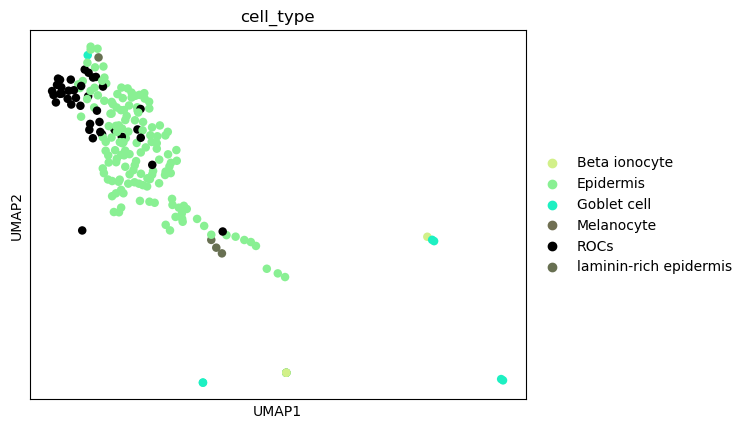

In [368]:
gene_markers = df2['names']  

skin_related_clusters = ['ROCs', 'Epidermis', 'laminin-rich epidermis', 'Melanocyte precursor', 
                         'Melanocyte stem cell', 'Melanocyte', 'Goblet cell', 'Alpha ionocyte', 
                         'Beta ionocyte', 'Small secretory cell']

adata_skin_related = adata[adata.obs['cluster'].isin(skin_related_clusters)].copy()

valid_genes = [gene for gene in gene_markers if gene in adata.var_names]

if not valid_genes:
    raise ValueError("None of the specified genes are found in the dataset!")

adata_skin_related_sub = adata_skin_related[:, valid_genes].copy()

expression_threshold = .4  
cell_mask = np.array((adata_skin_related_sub.X.mean(axis=1) > expression_threshold))

adata_skin_filtered = adata_skin_related[cell_mask].copy()

adata_skin_filtered.obs['cell_type'] = adata_skin_filtered.obs['cluster']

sc.tl.umap(adata_skin_filtered)
sc.pl.umap(adata_skin_filtered, color='cell_type', 
           palette=['#D2F089', '#89F093', '#1DF0C2', '#706F52', 'black', '#687052', '#F0E589', 'black', '#89F0B5', '#287BAE'], size =150)
